In [ ]:
# load libraries
import cv2
import numpy as np
import os
from keras.utils import np_utils
import matplotlib.pyplot as plt
import itertools
import time
from keras.models import Sequential
from keras.models import Model
from keras import applications
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Conv2D, Activation, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.metrics import log_loss
from sklearn.utils import class_weight
from keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
%matplotlib inline

split the data into train test and val subsets

In [ ]:
import splitfolders  # or import split_folders
input_folder='/content/drive/MyDrive/Stage/fpm_84/CAT01/Dataset'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values

# Split val/test with a fixed number of items e.g. 100 for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
splitfolders.fixed(input_folder, output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None) # default values


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  1.20 files/s]
Copying files: 32 files [00:00,  1.71 files/s]
Copying files: 67 files [00:01,  2.44 files/s]
Copying files: 94 files [00:01,  3.47 files/s]
Copying files: 127 files [00:01,  4.94 files/s]
Copying files: 158 files [00:01,  7.01 files/s]
Copying files: 188 files [00:01,  9.91 files/s]
Copying files: 215 files [00:01, 13.93 files/s]
Copying files: 242 files [00:01, 19.42 files/s]
Copying files: 271 files [00:01, 26.97 files/s]
Copying files: 301 files [00:01, 37.10 files/s]
Copying files: 329 files [00:01, 49.37 files/s]
Copying files: 359 files [00:02, 65.81 files/s]
Copying files: 387 files [00:02, 84.03 files/s]
Copying files: 414 files [00:02, 103.73 files/s]
Copying files: 440 files [00:02, 126.52 files/s]
Copying files: 467 files [00:02, 150.17 files/s]
Copying files: 493 files [00:02, 168.81 files/s]
Copying files: 519 files [00:02, 186.26 files/s]
Copying files: 544 files [00:02, 201.67 files

ValueError: ignored



This code is meant to use pretrained models to extract the features from the parasitized and uninfected cells to aid in improved malaria disease screening. However, you can use these codes as the skeleton to make use of pretrained models as feature extractors for your task of interest.Simply use this skeleton and extract the features from the most optimal layer from the model of your interest for the underlying data. You shall optimize the model hyperparameters to suit your data.


In [ ]:
#define data directories

train_data_dir = '/content/output/train'
valid_data_dir = '/content/output/val'
test_data_dir = '/content/output/test'

# declare the number of samples in each category
nb_train_samples = 1553 #  modify for your dataset
nb_valid_samples = 242 #  modify for your dataset
nb_test_samples = 179 # modify for your dataset
num_classes = 2 # binary classification 
img_rows_orig = 84 # modify these values depending on your requirements
img_cols_orig = 84 # modify these values depending on your requirements

In [ ]:

import cv2
#im = cv2.imread('/content/output/test/healthy/_healthy_3788_inten.png')

im = cv2.imread('/content/output/train/healthy/_healthy_3727_phase.png')

print(type(im))

print(im.shape)
print(type(im.shape))
# (225, 400, 3)
# <class 'tuple'>


<class 'numpy.ndarray'>
(84, 84, 3)
<class 'tuple'>


In [ ]:
img_cols

224

In [ ]:
#len(os.listdir('/content/output/val/healthy'))

230

Lets define functions to load and resize the training, validation and test data.

In [ ]:
from tensorflow import keras
import np_utils
import keras.utils.np_utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
def load_training_data():
    labels = os.listdir(train_data_dir)
    total = len(labels)
    X_train = np.ndarray((nb_train_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_train = np.zeros((nb_train_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating training images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_train = os.listdir(os.path.join(train_data_dir, label))
        total = len(image_names_train)
        print(label, total)
        for image_name in image_names_train:
            img = cv2.imread(os.path.join(train_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([img])
            X_train[i] = img
            Y_train[i] = j
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1    
    print(i)                
    print('Loading done.')
    print('Transform targets to keras compatible format.')
    Y_train = to_categorical(Y_train[:nb_train_samples], num_classes)
    np.save('imgs_train.npy', X_train, Y_train) #save as numpy files
    return X_train, Y_train
    
def load_validation_data():
    # Load validation images
    labels = os.listdir(valid_data_dir)
    X_valid = np.ndarray((nb_valid_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_valid = np.zeros((nb_valid_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating validation images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_valid = os.listdir(os.path.join(valid_data_dir, label))
        total = len(image_names_valid)
        print(label, total)
        for image_name in image_names_valid:
            img = cv2.imread(os.path.join(valid_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([img])
            X_valid[i] = img
            Y_valid[i] = j
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1
    print(i)            
    print('Loading done.')
    print('Transform targets to keras compatible format.');
    Y_valid = to_categorical(Y_valid[:nb_valid_samples], num_classes)
    np.save('imgs_valid.npy', X_valid, Y_valid) #save as numpy files
    return X_valid, Y_valid

def load_test_data():
    labels = os.listdir(test_data_dir)
    X_test = np.ndarray((nb_test_samples, img_rows_orig, img_cols_orig, 3), dtype=np.uint8)
    Y_test = np.zeros((nb_test_samples,), dtype='uint8')
    i = 0
    print('-'*30)
    print('Creating test images...')
    print('-'*30)
    j = 0
    for label in labels:
        image_names_test = os.listdir(os.path.join(test_data_dir, label))
        total = len(image_names_test)
        print(label, total)
        for image_name in image_names_test:
            img = cv2.imread(os.path.join(test_data_dir, label, image_name), cv2.IMREAD_COLOR)
            img = np.array([img])
            X_test[i] = img
            Y_test[i] = j
            if i % 100 == 0:
                print('Done: {0}/{1} images'.format(i, total))
            i += 1
        j += 1
    print(i)            
    print('Loading done.')
    print('Transform targets to keras compatible format.');
    Y_test = to_categorical(Y_test[:nb_test_samples], num_classes)
    np.save('imgs_test.npy', X_test, Y_test) #save as numpy files
    return X_test, Y_test

We will define functions to resize the original images to that dimensions required for the pretrained models

In [ ]:
def load_resized_training_data(img_rows, img_cols):

    X_train, Y_train = load_training_data()
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:nb_train_samples,:,:,:]])
    
    return X_train, Y_train
    
def load_resized_validation_data(img_rows, img_cols):

    X_valid, Y_valid = load_validation_data()
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:nb_valid_samples,:,:,:]])
        
    return X_valid, Y_valid   

def load_resized_test_data(img_rows, img_cols):

    X_test, Y_test = load_test_data()
    X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:nb_test_samples,:,:,:]])
    
    return X_test, Y_test

In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We will now proceed to extract the features from our dataset using the pretrained modelsand visualize the confusion matrix, ROC and AUC curves.

In [ ]:
from tensorflow import keras
import np_utils
import keras.utils.np_utils
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
input_shape=(84,84,3)
img_rows=224 #dimensions of image required for ResNet
img_cols=224
channel = 3 #RGB
num_classes = 2 #binary classification
batch_size = 32 # modify based on the GPUs in your system
num_epoch = 10 # modify depending on the model's convergence with your data

In [ ]:
#load data
load_training_data()
load_validation_data()
load_test_data()

------------------------------
Creating training images...
------------------------------
healthy 1450
Done: 0/1450 images
Done: 100/1450 images
Done: 200/1450 images
Done: 300/1450 images
Done: 400/1450 images
Done: 500/1450 images
Done: 600/1450 images
Done: 700/1450 images
Done: 800/1450 images
Done: 900/1450 images
Done: 1000/1450 images
Done: 1100/1450 images
Done: 1200/1450 images
Done: 1300/1450 images
Done: 1400/1450 images
infected 103
Done: 1500/103 images
1553
Loading done.
Transform targets to keras compatible format.
------------------------------
Creating validation images...
------------------------------
healthy 230
Done: 0/230 images
Done: 100/230 images
Done: 200/230 images
infected 12
242
Loading done.
Transform targets to keras compatible format.
------------------------------
Creating test images...
------------------------------
healthy 165
Done: 0/165 images
Done: 100/165 images
infected 14
179
Loading done.
Transform targets to keras compatible format.


(array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         ...,
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],
 
 
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0

In [ ]:
X_train, Y_train = load_resized_training_data(img_rows, img_cols)
X_valid, Y_valid = load_resized_validation_data(img_rows, img_cols)
X_test, Y_test = load_resized_test_data(img_rows, img_cols)

------------------------------
Creating training images...
------------------------------
healthy 1450
Done: 0/1450 images
Done: 100/1450 images
Done: 200/1450 images
Done: 300/1450 images
Done: 400/1450 images
Done: 500/1450 images
Done: 600/1450 images
Done: 700/1450 images
Done: 800/1450 images
Done: 900/1450 images
Done: 1000/1450 images
Done: 1100/1450 images
Done: 1200/1450 images
Done: 1300/1450 images
Done: 1400/1450 images
infected 103
Done: 1500/103 images
1553
Loading done.
Transform targets to keras compatible format.
------------------------------
Creating validation images...
------------------------------
healthy 230
Done: 0/230 images
Done: 100/230 images
Done: 200/230 images
infected 12
242
Loading done.
Transform targets to keras compatible format.
------------------------------
Creating test images...
------------------------------
healthy 165
Done: 0/165 images
Done: 100/165 images
infected 14
179
Loading done.
Transform targets to keras compatible format.


In [ ]:
#print the shape of the data
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(1553, 224, 224, 3) (1553, 2)
(242, 224, 224, 3) (242, 2)
(179, 224, 224, 3) (179, 2)


In [ ]:
feature_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
feature_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3)) 
feature_model = Model(inputs=feature_model.input, outputs=feature_model.get_layer('conv5_block3_out').output)
feature_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Lets modify the architecture by adding a global spatial average pooling layer and a fully-connected layer with a dropout ratio of 0.5 to prevent overfitting and help model generalization. We will train only the top layers which are randomly initialized, freeze all the convolutional layers to prevent large gradient updates wrecking the learned weights

In [ ]:
x = feature_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

# this is the model we will train
model = Model(inputs=feature_model.input, outputs=predictions)

# Train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers to prevent large gradient updates wrecking the learned weights
for layer in feature_model.layers:
    layer.trainable = False

#fix the optimizer
sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True) 

#compile the model
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.weights

[<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
 array([[[[ 2.82526277e-02, -1.18737184e-02,  1.51488732e-03, ...,
           -1.07003953e-02, -5.27982824e-02, -1.36667420e-03],
          [ 5.86827798e-03,  5.04415408e-02,  3.46324709e-03, ...,
            1.01423981e-02,  1.39493728e-02,  1.67549420e-02],
          [-2.44090753e-03, -4.86173332e-02,  2.69966386e-03, ...,
           -3.44439060e-04,  3.48098315e-02,  6.28910400e-03]],
 
         [[ 1.81872323e-02, -7.20698107e-03,  4.80302610e-03, ...,
           -7.43396254e-03, -8.56800564e-03,  1.16849300e-02],
          [ 1.87554304e-02,  5.12730293e-02,  4.50406177e-03, ...,
            1.39413681e-02,  1.26296384e-02, -1.73004344e-02],
          [ 1.90453827e-02, -3.87909152e-02,  4.25842637e-03, ...,
            2.75742816e-04, -1.27962548e-02, -8.35626759e-03]],
 
         [[ 1.58849321e-02, -1.06073255e-02,  1.30999666e-02, ...,
           -2.26797583e-03, -3.98984266e-04,  3.39989027e-04],
      

In [ ]:
!sudo pip install --upgrade git+https://github.com/fchollet/keras

  Cloning https://github.com/fchollet/keras to /tmp/pip-req-build-ee2v3bwp
  Running command git clone -q https://github.com/fchollet/keras /tmp/pip-req-build-ee2v3bwp
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')



Its time to train the model. We will store only the best model weights by initializing callbacks. Also we can view the performance of our model during run-time by visualizing the performance graphs with Tensorboard. Create a log directory named 'logs' to store the training logs and a separate folder named 'weights' to store the model weights.


In [ ]:
filepath = "/content/my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_weights_only=True, save_best_only=True, mode='max', period=1)
tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0, batch_size=batch_size)
callbacks_list = [checkpoint, tensor_board]

#compute training time
t=time.time()
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 callbacks=callbacks_list,
                 epochs=num_epoch, verbose=1, 
                 shuffle=True, 
                 #validation_data=[X_valid, Y_valid]
                 )

#compute the training time
print('Training time: %s' % (time.time()-t))

Epoch 1/10
49/49 [==============================] - 211s 4s/step - loss: 0.2901 - accuracy: 0.9195
Epoch 2/10
49/49 [==============================] - 209s 4s/step - loss: 0.2733 - accuracy: 0.9259
Epoch 3/10
49/49 [==============================] - 208s 4s/step - loss: 0.2660 - accuracy: 0.9272
Epoch 4/10
49/49 [==============================] - 206s 4s/step - loss: 0.2721 - accuracy: 0.9305
Epoch 5/10
49/49 [==============================] - 207s 4s/step - loss: 0.2676 - accuracy: 0.9266
Epoch 6/10
49/49 [==============================] - 207s 4s/step - loss: 0.2668 - accuracy: 0.9324
Epoch 7/10
49/49 [==============================] - 207s 4s/step - loss: 0.2623 - accuracy: 0.9272
Epoch 8/10
49/49 [==============================] - 207s 4s/step - loss: 0.2562 - accuracy: 0.9266
Epoch 9/10
49/49 [==============================] - 206s 4s/step - loss: 0.2449 - accuracy: 0.9285
Epoch 10/10
49/49 [==============================] - 207s 4s/step - loss: 0.2528 - accuracy: 0.9259
Training 

In [ ]:
from keras.models import load_model

model.save('my_model_new.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model_new.h5')

In [ ]:
hist.history

{'accuracy': [0.9195106029510498,
  0.92594975233078,
  0.9272376298904419,
  0.9304571747779846,
  0.9265936613082886,
  0.9323889017105103,
  0.9272376298904419,
  0.9265936613082886,
  0.928525447845459,
  0.92594975233078],
 'loss': [0.2900889217853546,
  0.2733480930328369,
  0.2659723460674286,
  0.2720710039138794,
  0.26756641268730164,
  0.26676779985427856,
  0.26231053471565247,
  0.25621742010116577,
  0.2448538839817047,
  0.2527811825275421]}

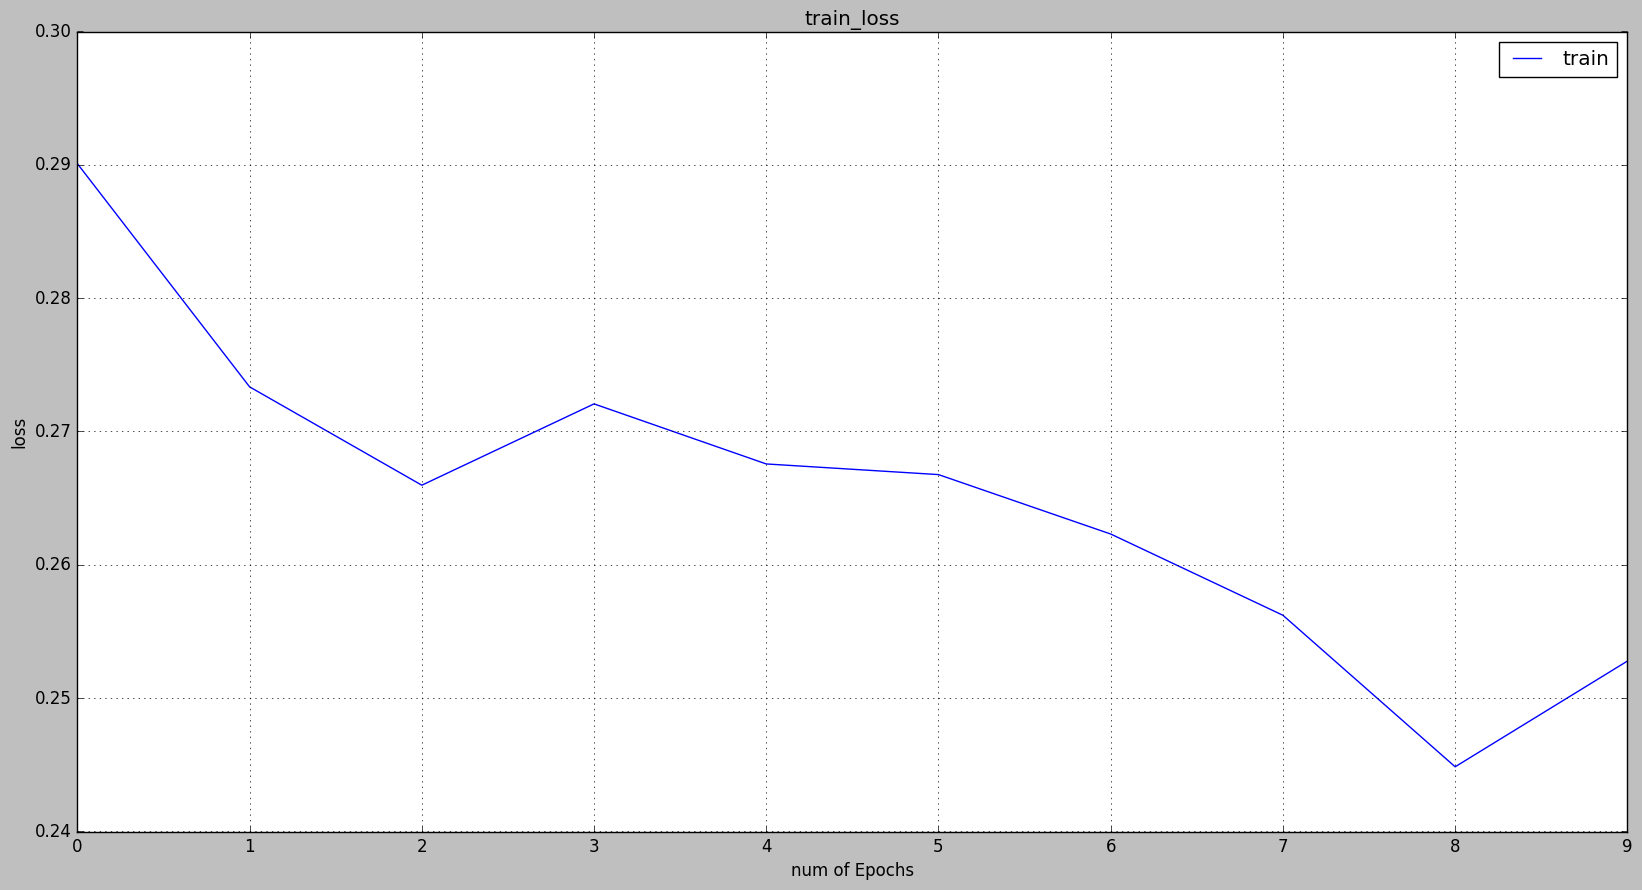

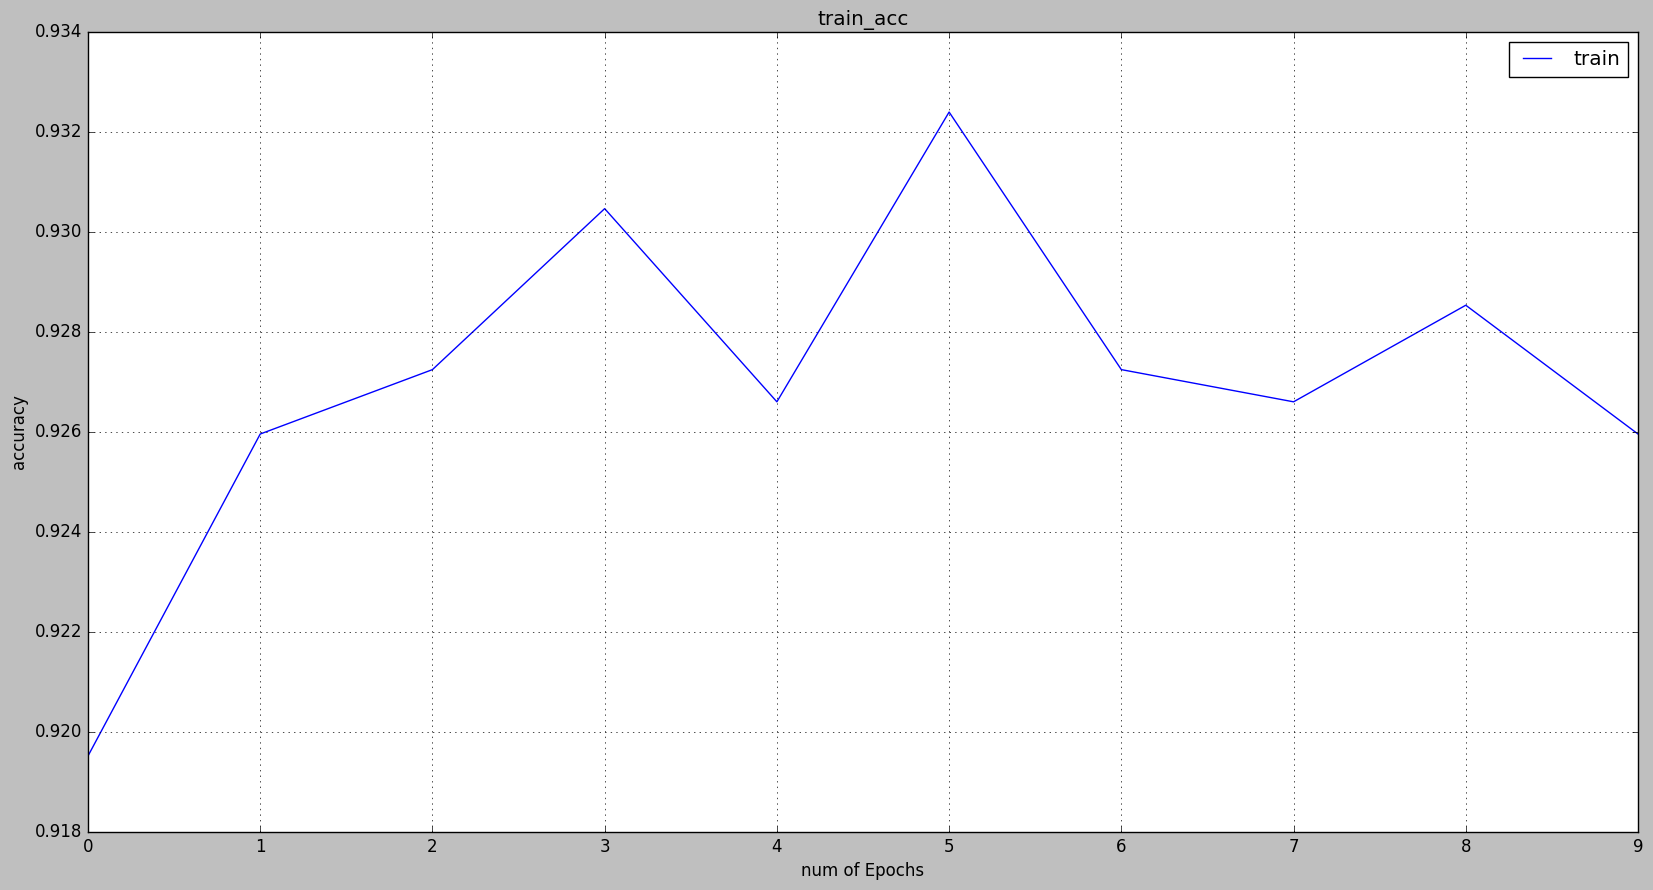

In [ ]:
#visualize the performance of the model
train_loss=hist.history['loss']
#val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
#val_acc=hist.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(20,10), dpi=100)
plt.plot(xc,train_loss)
#plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

plt.figure(2,figsize=(20,10), dpi=100)
plt.plot(xc,train_acc)
#plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc')
plt.grid(True)
plt.legend(['train','val'])
plt.style.use(['classic'])

Once the model is trained, load the best model weights to predict on the test data.

In [ ]:
#modify
#model.load_weights('/content/my_model_new.h5')

In [ ]:
#predict on the test data
X_test, Y_test = load_resized_test_data(img_rows, img_cols)
print(X_test.shape, Y_test.shape)
print('-'*30)
print('Predicting on the test data...')
print('-'*30)
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

# compute the accuracy
Test_accuracy = accuracy_score(Y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
print("Test_Accuracy = ",Test_accuracy)

------------------------------
Creating test images...
------------------------------
healthy 165
Done: 0/165 images
Done: 100/165 images
infected 14
179
Loading done.
Transform targets to keras compatible format.
(179, 224, 224, 3) (179, 2)
------------------------------
Predicting on the test data...
------------------------------
6/6 [==============================] - 25s 4s/step
Test_Accuracy =  0.9217877094972067


Let us now compute the performance metrics for the pretrained Resnet model with the test data. The performance metrics involve computing the ROC-AUC values, cross-entropy loss score, average precision score, prediction probabilities and storing these values and plotting the ROC curves.

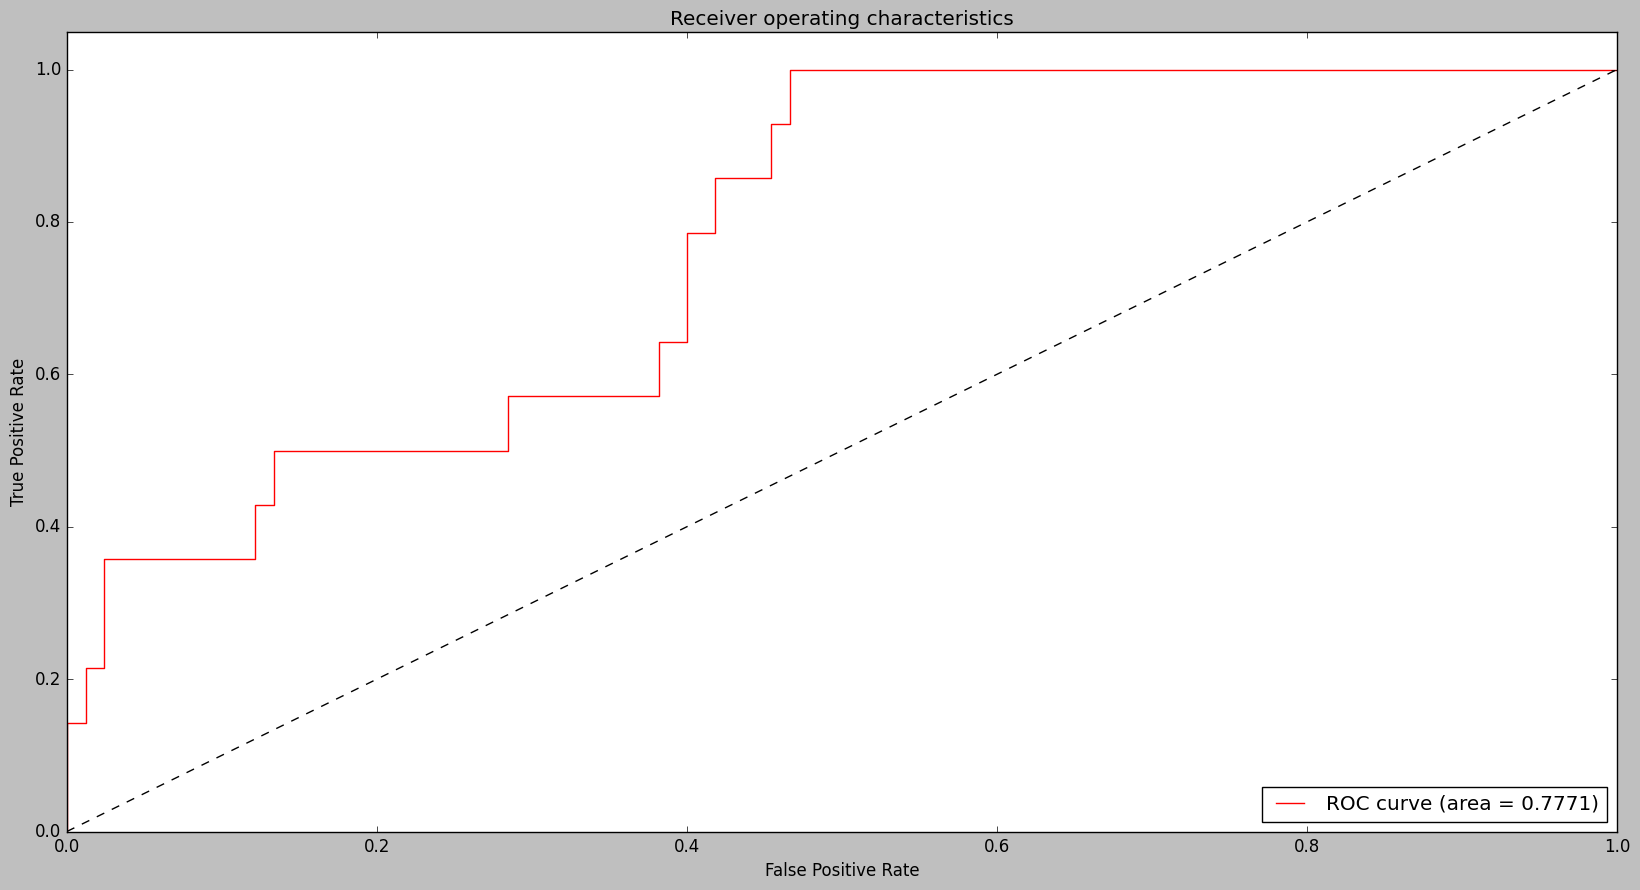

0.25944905028569215
0.671637083499351
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#Plot ROC curves
plt.figure(figsize=(20,10), dpi=100)
lw = 1
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

# computhe the cross-entropy loss score
score = log_loss(Y_test,y_pred)
print(score)

# compute the average precision score
prec_score = average_precision_score(Y_test,y_pred)  
print(prec_score)

# transfer it back
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
print(y_pred)
print(Y_test)

#save the predictions as a CSV file for further analysis
np.savetxt('resnet_model_y_pred.csv',y_pred,fmt='%i',delimiter = ",")
np.savetxt('resnet_model_Y_test.csv',Y_test,fmt='%i',delimiter = ",")

Now, let us plot the confusion matrix of the model's performance.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  str(average_options))


              precision    recall  f1-score   support

     healthy       0.92      1.00      0.96       165
    infected       0.00      0.00      0.00        14

    accuracy                           0.92       179
   macro avg       0.46      0.50      0.48       179
weighted avg       0.85      0.92      0.88       179

[[165   0]
 [ 14   0]]
Confusion matrix, without normalization
[[165   0]
 [ 14   0]]


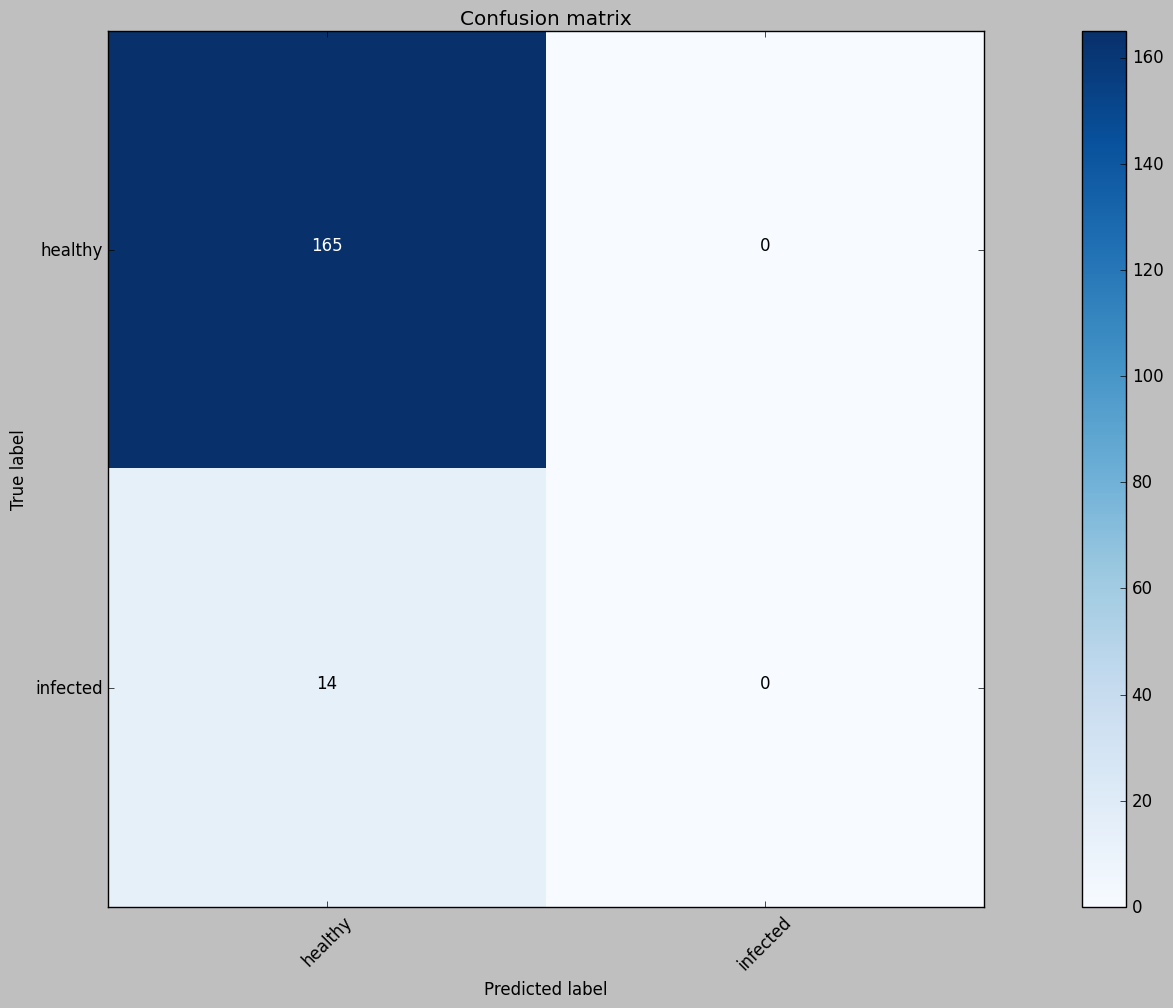

In [ ]:
target_names = ['healthy', 'infected'] #decide the labels for your own data
print(classification_report(Y_test,y_pred,target_names=target_names))
print(confusion_matrix(Y_test,y_pred))
cnf_matrix = (confusion_matrix(Y_test,y_pred))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=100)
plot_confusion_matrix(cnf_matrix, classes=target_names,
                  title='Confusion matrix')
plt.show()

In [ ]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

     |████████████████████████████████| 11.1MB 10.6MB/s 
     |████████████████████████████████| 112kB 37.0MB/s 
  Created wheel for Pillow: filename=Pillow-4.0.0-cp37-cp37m-linux_x86_64.whl size=1007174 sha256=553cc5bc9202ba282910405faffb80325991785bda1a939622998c3e0e0f87b0
  Stored in directory: /root/.cache/pip/wheels/4f/0a/2a/7e3391063af230fac4b5fdb4cc93adcb1d99af325b623cea03
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=66442a8e854df9872a54a6f9dd34e15fefd95ffae50b0853351946c498d1f081
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built Pillow olefile
ERROR: torchvision 0.9.0+cu101 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 w

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


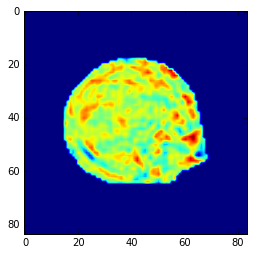

In [ ]:
import matplotlib.image as mpimg
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()
#load image to be predicted
img_path = '/content/output/test/infected/_infected_2895_phase.png' 
img=mpimg.imread(img_path)
plt.imshow(img)


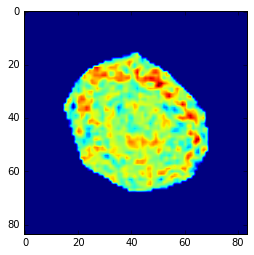

In [ ]:
img_path = '/content/output/test/healthy/_healthy_3757_phase.png' 
img=mpimg.imread(img_path)
plt.imshow(img)

In [ ]:
from PIL import Image
import tensorflow as tf

img_data = '/content/output/test/healthy/_healthy_3757_phase.png'

img_data = np.random.random(size=(84, 84, 3))
img = tf.keras.preprocessing.image.array_to_img(img_data)
array = tf.keras.preprocessing.image.img_to_array(img)

In [ ]:
#preprocess the image
#x = np.expand_dims(img, axis=0)
x = img_data.resize((224, 224,3))

In [ ]:
#predict on the image
preds = model.predict(x)[0]

ValueError: ignored

In [ ]:
#grad-CAM visualization and heat-map
malaria_output = model.output[:, 0] #index of the positive (abnormal) class

#deepest convolutional layer in the trained model
model.summary()
last_conv_layer = model.get_layer('conv5_block3_out')

#compute the Gradient of the expected class (abnormal) with regard to the 
#output feature map of the deepst convolutional layer
grads = K.gradients(malaria_output, last_conv_layer.output)[0]

#Vector of shape (512,), where each entry is the mean intensity of the gradient over a specific feature-map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

#Lets you access the values of the quantities you just defined: pooled_grads and the
#output feature map of block5_conv2, given the input image
iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

#Values of these two quantities, as Numpy arrays, given the input abnormal image
pooled_grads_value, conv_layer_output_value = iterate([x])

#Multiplies each channel in the feature-map array by “how important this channel is” with regard to the “abnormal” class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
#For visualization purposes, we normalize the heatmap between 0 and 1.
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

# we OpenCV to generate an image that superimposes the original image
#on the heatmap obtained
img = cv2.imread(img_path)

#Resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

#Converts the heatmap to RGB 
heatmap = np.uint8(255 * heatmap)

#Applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img #0.4 here is a heatmap intensity factor

#Saves the image to disk
cv2.imwrite('CAM_parasitic_cell.jpg', superimposed_img)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

RuntimeError: ignored



These visualization techniques answer two important questions: Why did the network think this is a parasitic cell? Where is the parasite seen in the cell image? In particular, it’s interesting to note that the areas showing the parasites are strongly activated: this is probably how the network can tell the difference between normal and abnormal (parasitic) cells.
